# Graded Lab Assignment 2: Evaluate classifiers (10 points)
 
In this assignment you will optimize and compare the perfomance of a parametric (logistic regression) and non-parametric (k-nearest neighbours) classifier on the MNIST dataset.

Publish your notebook (ipynb file) to your Machine Learning repository on Github ON TIME. We will check the last commit on the day of the deadline.  

### Deadline Friday, November 17, 23:59.

This notebook consists of three parts: design, implementation, results & analysis. 
We provide you with the design of the experiment and you have to implement it and analyse the results.

### Criteria used for grading
* Explain and analyse all results.
* Make your notebook easy to read. When you are finished take your time to review it!
* You do not want to repeat the same chunks of code multiply times. If your need to do so, write a function. 
* The implementation part of this assignment needs careful design before you start coding. You could start by writing pseudocode.
* In this exercise the insights are important. Do not hide them somewhere in the comments in the implementation, but put them in the Analysis part
* Take care that all the figures and tables are well labeled and numbered so that you can easily refer to them.
* A plot should have a title and axes labels.
* You may find that not everything is 100% specified in this assignment. That is correct! Like in real life you probably have to make some choices. Motivate your choices.


### Grading points distribution

* Implementation 5 points
* Results and analysis 5 points

## Design of the experiment

You do not have to keep the order of this design and are allowed to alter it if you are confident.
* Import all necessary modules. Try to use as much of the available functions as possible. 
* Use the provided train and test set of MNIST dataset.
* Pre-process data eg. normalize/standardize, reformat, etc.           
  Do whatever you think is necessary and motivate your choices.
* (1) Train logistic regression and k-nn using default settings.
* Use 10-fold cross validation for each classifier to optimize the performance for one parameter: 
    * consult the documentation on how cross validation works in sklearn (important functions:             cross_val_score(), GridSearchCV()).
    * Optimize k for k-nn,
    * for logistic regression focus on the regularization parameter,
* (2) Train logistic regression and k-nn using optimized parameters.
* Show performance on the cross-validation set for (1) and (2) for both classifiers: 
    * report the average cross validation error rates (alternatively, the average accuracies - it's up to you) and standard deviation,
    * plot the average cross valildation errors (or accuracies) for different values of the parameter that you tuned. 
* Compare performance on the test set for two classifiers:
    * produce the classification report for both classifiers, consisting of precision, recall, f1-score. Explain and analyse the results.
    * print confusion matrix for both classifiers and compare whether they missclassify the same  classes. Explain and analyse the results.
* Discuss your results.
* BONUS: only continue with this part if you are confident that your implemention is complete 
    * tune more parameters of logistic regression
    * add additional classifiers (NN, Naive Bayes, decision tree), 
    * analyse additional dataset (ex. Iris dataset)

## Implementation of the experiment

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# load all libraries and modules
from sklearn.datasets import load_digits
import numpy as np
from sklearn import datasets # to load the dataset
from sklearn.model_selection import train_test_split #to split in train and test set
from sklearn.model_selection import cross_val_score, GridSearchCV #BONUS
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix # for reporting
from sklearn.preprocessing import StandardScaler # to normalize data (NN is very sensitive to this!)
from sklearn.neighbors import KNeighborsClassifier # k nearest neighbour classifier
from sklearn.neural_network import MLPClassifier # neural network classifier
from sklearn.linear_model import LogisticRegression #logistic regression classifier
from sklearn.naive_bayes import GaussianNB # for BONUS
from sklearn.tree import DecisionTreeClassifier # for BONUS

In [39]:
# load mnist dataset and split in train and test set.
digits = datasets.load_digits()
X_train_mnist = np.reshape(digits.images[:1500],(1500,64))
X_test_mnist = np.reshape(digits.images[1500:],(297,64))
y_train_mnist = digits.target[:1500]
y_test_mnist = digits.target[1500:]

In [4]:
#preprocess data (normalisation)
scaler = StandardScaler()
scaler.fit(X_train_mnist)
scaler.fit(X_test_mnist)
normalised_X_train = scaler.transform(X_train_mnist) # output scaled data in new variables
normalised_X_test = scaler.transform(X_test_mnist)

In [23]:
#Train logistic regression and k-nn using default settings.
log_regr = LogisticRegression()
k_nn_classifier = KNeighborsClassifier()
log_regr.fit(normalised_X_train, y_train_mnist)
k_nn_classifier.fit(normalised_X_train, y_train_mnist)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [24]:
def report_accuracy(moment, clf_name, clf, x_train, y_train):
    cv_error = cross_val_score(clf, x_train, y_train, scoring="accuracy", cv=10)
    print(moment + " customisation, average accuracy of " + clf_name + " : ", cv_error.mean(), " standard deviation: ", np.std(cv_error))

In [25]:
#Use 10-fold cross validation for each classifier to optimize the performance for one parameter:
#10-fold cross-validation, before tuning
report_accuracy("Before", "LR", log_regr, normalised_X_train, y_train_mnist)
report_accuracy("Before", "KNN", k_nn_classifier, normalised_X_train, y_train_mnist)

Before customisation, average accuracy of LR :  0.941446300269  standard deviation:  0.0205180253743
Before customisation, average accuracy of KNN :  0.948266646885  standard deviation:  0.0303457070823


In [26]:
def tune_single_param(clf, param_name, param_grid, x_train, y_train):
    grid_search = GridSearchCV(clf, param_grid=param_grid, cv=10)
    grid_search.fit(x_train, y_train)
    best_param = list(grid_search.best_params_.values())[0]
    plt.plot(param_grid[param_name], grid_search.cv_results_['mean_test_score']) # plot accuracy scores against parameters
    plt.xlabel("Parameters")
    plt.ylabel("Scores")
    return best_param

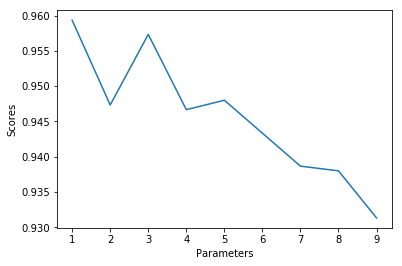

In [27]:
# Optimize k for k-nn with GridSearchCV
k_param = {'n_neighbors': np.arange(1, 10)} # number of k neighbours from 1 to 10
best_K = tune_single_param(KNeighborsClassifier(), 'n_neighbors', k_param, normalised_X_train, y_train_mnist)
#print(best_K)

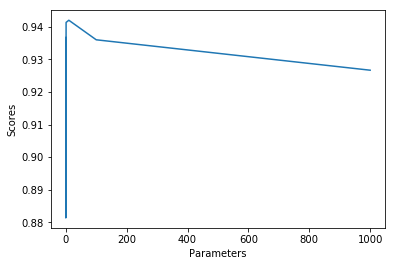

In [28]:
#tune lambda with GridSearchCV
lambda_param = {'C': [0.1, 0.01, 0.001, 1, 10, 100, 1000]} # regularisation params to be considered
best_C = tune_single_param(LogisticRegression(), 'C', lambda_param, normalised_X_train, y_train_mnist)
#print(best_C)

In [29]:
# Train logistic regression and k-nn using optimized parameters.
log_regr_customised = LogisticRegression(C=best_C)
knn_customised = KNeighborsClassifier(n_neighbors=best_K)
log_regr_customised.fit(normalised_X_train, y_train_mnist)
knn_customised.fit(normalised_X_train, y_train_mnist)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [30]:
#Show performance on the cross-validation set for (1) and (2) for both classifiers: 
#    * report the average cross validation error rates (alternatively, the average accuracies - it's up to you) 
#and standard deviation, after tuning
report_accuracy("After", "LR", log_regr_customised, normalised_X_train, y_train_mnist)
report_accuracy("After", "KNN", knn_customised, normalised_X_train, y_train_mnist)

After customisation, average accuracy of LR :  0.942180286678  standard deviation:  0.0191189588715
After customisation, average accuracy of KNN :  0.959534823035  standard deviation:  0.0271404395113


In [31]:
#* Compare performance on the test set for two classifiers:
#    * produce the classification report for both classifiers, consisting of precision, recall, f1-score. 
def produce_report(clf_name, clf, x_test, y_test):
    preds = clf.predict(x_test)
    print(clf_name + "'s accuracy: ", accuracy_score(y_test, preds))
    print("Report for " + clf_name + " :\n", classification_report(y_test, preds))
    return preds
log_predictions = produce_report("Logistic Regression", log_regr_customised, normalised_X_test, y_test_mnist)
knn_predictions = produce_report("KNN", knn_customised, normalised_X_test, y_test_mnist)

Logistic Regression's accuracy:  0.878787878788
Report for Logistic Regression :
              precision    recall  f1-score   support

          0       0.96      0.93      0.94        27
          1       0.79      0.84      0.81        31
          2       1.00      1.00      1.00        27
          3       0.86      0.63      0.73        30
          4       0.91      0.91      0.91        33
          5       0.91      0.97      0.94        30
          6       0.97      0.97      0.97        30
          7       0.90      0.87      0.88        30
          8       0.68      0.89      0.77        28
          9       0.89      0.81      0.85        31

avg / total       0.89      0.88      0.88       297

KNN's accuracy:  0.929292929293
Report for KNN :
              precision    recall  f1-score   support

          0       1.00      1.00      1.00        27
          1       0.89      1.00      0.94        31
          2       1.00      0.89      0.94        27
          3     

###    Explain and analyse Classification Reports
In the two classification reports above, what can be seen is the clearly better performance of the K Nearest Neighbour (KNN) classifier on all scoring categories (precision, recall and f1-score), and hence its accuracy score is also significantly higher (0.93 compared to Logistic Regression's (LR) 0.88). It's worth noting that the number of k-nearest-neighbours that was classified as best by the `GridSearchCV` module in the cross-validation phase was 1, this means that there is a clear separation of labels between the instances of the training set `X_train_mnist` (or `normalised_X_train`).

In the `precision` score ($tp/P$), while LR performed rather poorly in class 8 (0.68), KNN scored perfectly. The same thing can be seen with the `recall` score ($tp/(tp+fn)$) in class 3, where LR scored 0.63 and KNN scored 0.90.

In [32]:
# print confusion matrix for both classifiers and compare whether they missclassify the same  classes. 
log_cm = confusion_matrix(y_test_mnist, log_predictions)
knn_cm = confusion_matrix(y_test_mnist, knn_predictions)
print("Confusion matrix for Logistic Regression: \n", log_cm, "\n")
print("Confusion matrix for K Nearest Neighbours:\n", knn_cm)

Confusion matrix for Logistic Regression: 
 [[25  0  0  0  1  0  1  0  0  0]
 [ 0 26  0  2  0  0  0  0  3  0]
 [ 0  0 27  0  0  0  0  0  0  0]
 [ 0  1  0 19  0  3  0  2  5  0]
 [ 0  0  0  0 30  0  0  0  0  3]
 [ 0  1  0  0  0 29  0  0  0  0]
 [ 0  1  0  0  0  0 29  0  0  0]
 [ 0  0  0  0  1  0  0 26  3  0]
 [ 0  2  0  0  1  0  0  0 25  0]
 [ 1  2  0  1  0  0  0  1  1 25]] 

Confusion matrix for K Nearest Neighbours:
 [[27  0  0  0  0  0  0  0  0  0]
 [ 0 31  0  0  0  0  0  0  0  0]
 [ 0  0 24  0  0  0  3  0  0  0]
 [ 0  0  0 27  0  1  1  1  0  0]
 [ 0  0  0  0 29  0  0  1  0  3]
 [ 0  1  0  0  1 28  0  0  0  0]
 [ 0  0  0  0  0  0 30  0  0  0]
 [ 0  0  0  0  0  0  0 30  0  0]
 [ 0  3  0  1  0  0  0  0 23  1]
 [ 0  0  0  1  0  2  0  1  0 27]]


### Explain and analyse Confusion Matrices
The two confusion matrices ($m$ x $n$) above present the performances of two classifiers on the test set (`normalised_X_test`) that contains 10 classes (from 0 to 9). Their diagonals reflect the number of instances that were predicted correctly for each class. While for each entry $E$ that is not on the diagonal, $E_{i,j}$ is the number of instances that are supposed to be in class $i$ but were misclassified as class $j$. Looking at these 2 matrices, one can see that both classifiers misclassified class 3, 4, 5, 8 and 9. For example, in class 3, LR only correctly classified 19 instances, and 1 instance was misclassified as class 1, 3 as class 5, 2 as class 7 and 5 as class 8; hence it produced a recall score of 0.63.

### Discuss your results
The implementation of LR and KNN in this notebook indicates the following points:

 - Using cross validation to tune the parameters, specifically, k and lambda, did produce an improvement in the accuracy score of both classifiers. The best k was found to be 1, while the best regularisation parameter lambda was 10. The `GridSearchCV` was of great help in finding these, due to its iterating over each value of the parameters and calculating the cross validation score of each. In the Bonus this module is also further exploited, however due to the heaviness of this notebook it `GridSearchCV` extremely long to produce output via its property `best_params_` when dealing with more than 1 parameter type, and hence I had to use it separately.
 - The reports and confusion matrices showed a better performance of the KNN classifier in the test set (normalised), with an average accuracy score of 0.93 in all scoring cateogories. Meanwhile, LR observed some low scores in class 3 for `recall` and 8 for `precision`. This indicates the efficiency of the KNN classifier in dealing with this particular dataset. 

### BONUS

In [5]:
from sklearn import datasets

In [37]:
# load iris dataset, with 4 features, tried doing it with 2 features and the scores were really low for all classifiers
iris = datasets.load_iris()
features = iris.data[:, : 4] 
labels = iris.target
scaler = StandardScaler()
scaler.fit(features)
features = scaler.transform(features)
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(features, labels)
X_train_iris.shape

(112, 4)

The two cells below try to tune the two parameters `max_iter` and `penalty` of the `LogisticRegression` classifier. The two parameters could have been put into one dictionary called `param_grid` but doing that made my notebook extremely heavy and nearly crashed my whole system. So yes there's a redundancy of code but the notebook doesn't allow me to do otherwise :(

In [7]:
# tune more parameters of logistic regression
iter_grid = {'max_iter': [100, 200, 300, 400, 500]}
gs = GridSearchCV(LogisticRegression(C=10), param_grid=iter_grid, cv=10)
gs.fit(normalised_X_train, y_train_mnist)
gs.best_params_

{'max_iter': 100}

In [8]:
penalty_grid = {'penalty': ['l1', 'l2']}
gs = GridSearchCV(LogisticRegression(C=10), param_grid=penalty_grid, cv=10)
gs.fit(normalised_X_train, y_train_mnist)
gs.best_params_

{'penalty': 'l2'}

In [41]:
def classifier_preds(clf, set_name, x_train, x_test, y_train, y_test):
    preds = clf.fit(x_train, y_train).predict(x_test)
    print("accuracy score for " + set_name +" set: ", accuracy_score(y_test, preds))
    print("classification report for " + set_name + " set: \n", classification_report(y_test, preds))

In [42]:
# NB
bayes_classifier = GaussianNB()
classifier_preds(bayes_classifier, "mnist", normalised_X_train, normalised_X_test, y_train_mnist, y_test_mnist)
classifier_preds(bayes_classifier, "iris", X_train_iris, X_test_iris, y_train_iris, y_test_iris)

accuracy score for mnist set:  0.794612794613
classification report for mnist set: 
              precision    recall  f1-score   support

          0       0.96      0.96      0.96        27
          1       0.68      0.87      0.76        31
          2       0.95      0.70      0.81        27
          3       1.00      0.47      0.64        30
          4       0.96      0.82      0.89        33
          5       0.78      0.97      0.87        30
          6       0.97      0.97      0.97        30
          7       0.60      0.87      0.71        30
          8       0.53      0.68      0.59        28
          9       0.91      0.65      0.75        31

avg / total       0.84      0.79      0.79       297

accuracy score for iris set:  0.973684210526
classification report for iris set: 
              precision    recall  f1-score   support

          0       1.00      1.00      1.00        13
          1       1.00      0.92      0.96        12
          2       0.93      1.00 

In [43]:
# Decision Tree
dec_tree = DecisionTreeClassifier(random_state=1)
classifier_preds(dec_tree, "mnist", normalised_X_train, normalised_X_test, y_train_mnist, y_test_mnist)
classifier_preds(dec_tree, "iris", X_train_iris, X_test_iris, y_train_iris, y_test_iris)

accuracy score for mnist set:  0.784511784512
classification report for mnist set: 
              precision    recall  f1-score   support

          0       0.93      0.96      0.95        27
          1       0.74      0.65      0.69        31
          2       0.81      0.78      0.79        27
          3       0.70      0.63      0.67        30
          4       0.79      0.91      0.85        33
          5       0.81      0.87      0.84        30
          6       0.96      0.83      0.89        30
          7       0.70      0.87      0.78        30
          8       0.58      0.54      0.56        28
          9       0.83      0.81      0.82        31

avg / total       0.79      0.78      0.78       297

accuracy score for iris set:  0.947368421053
classification report for iris set: 
              precision    recall  f1-score   support

          0       1.00      1.00      1.00        13
          1       0.86      1.00      0.92        12
          2       1.00      0.85 

In [44]:
# NN, tuning number of layers
layer_grid = {'hidden_layer_sizes': [(100,), (200,), (300,), (400,)]}
#, 'activation': ['identity', 'logistic', 'tanh', 'relu'], 'alpha': [0.1, 0.01, 0.001, 0.0001, 1], 'max_iter': [100, 200, 300, 400, 500]}
gs_nn = GridSearchCV(MLPClassifier(), param_grid=layer_grid, cv=10)
gs_nn.fit(normalised_X_train, y_train_mnist).best_params_

{'hidden_layer_sizes': (200,)}

In [46]:
nn_classifier = MLPClassifier(hidden_layer_sizes=(200,), max_iter=500)
classifier_preds(nn_classifier, "mnist", normalised_X_train, normalised_X_test, y_train_mnist, y_test_mnist)
classifier_preds(nn_classifier, "iris", X_train_iris, X_test_iris, y_train_iris, y_test_iris)

accuracy score for mnist set:  0.912457912458
classification report for mnist set: 
              precision    recall  f1-score   support

          0       0.96      0.93      0.94        27
          1       0.94      1.00      0.97        31
          2       1.00      1.00      1.00        27
          3       0.95      0.60      0.73        30
          4       0.97      0.91      0.94        33
          5       0.88      1.00      0.94        30
          6       0.97      0.97      0.97        30
          7       0.88      0.93      0.90        30
          8       0.74      0.93      0.83        28
          9       0.90      0.87      0.89        31

avg / total       0.92      0.91      0.91       297

accuracy score for iris set:  1.0
classification report for iris set: 
              precision    recall  f1-score   support

          0       1.00      1.00      1.00        13
          1       1.00      1.00      1.00        12
          2       1.00      1.00      1.00  

### Some comments.

What can be seen from the examples above is that the classifiers obtained better performance in the iris dataset than the mnist dataset, especially in the case of the Decision Tree and the Naive Bayes. It is worth noting that the mnist dataset contained 1500 training examples and 64 features, compared to 112 examples and 4 features of the iris set. Therefore, what may have happened in the Decision Tree classification was overfitting: with such a large number of features, the number of splits became larger and larger and this may have resulted in situations where singleton = pure $\Rightarrow$ not able to deal with the test set. Meanwhile, with Naive Bayes, which constitutes a simple linear hypothesis function, the problem was likely underfitting. This means that the large number of data was the cause for the classifier not fitting the data well and hence did not perform well on the test set either.